# INIT

In [ ]:
!pip uninstall --yes tensorboard tb-nightly
# !pip install --quiet --upgrade tensorflow-federated-nightly tfa-nightly nest-asyncio 
!pip install --quiet --upgrade tensorflow-federated tensorflow-addons nest-asyncio 
# !pip install --quiet --upgrade tensorflow-addons
# !pip install --quiet --upgrade nest-asyncio
# !pip install --quiet --upgrade tb-nightly
import nest_asyncio
nest_asyncio.apply()

Uninstalling tensorboard-2.5.0:
  Successfully uninstalled tensorboard-2.5.0
     |████████████████████████████████| 604kB 26.6MB/s 
     |████████████████████████████████| 686kB 18.4MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 194kB 57.6MB/s 
     |████████████████████████████████| 174kB 61.2MB/s 
     |████████████████████████████████| 6.0MB 36.7MB/s 
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
ERROR: pymc3 3.11.2 has requirement cachetools>=4.2.1, but you'll have cachetools 3.1.1 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.28.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
import collections
import numpy as np

import tensorflow_federated as tff
import pandas as pd
import math
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
import tensorflow as tf
import datetime

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import random

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, f1_score
import IPython.display as ipd
%matplotlib inline

RANDOM_STATE = 1

np.random.seed(RANDOM_STATE) # NumPy
random.seed(RANDOM_STATE) # Python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train_transaction.csv")
data = data.sample(frac=1, random_state=RANDOM_STATE )
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
67316,3054316,0,1531926,50.00,R,7664,490.0,150.0,visa,226.0,debit,264.0,87.0,NaN,NaN,yahoo.com,yahoo.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,316.708344,0.708333,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182840,3169840,0,4048121,29.00,W,14426,111.0,150.0,mastercard,224.0,debit,272.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,10.0,10.0,4.0,10.0,4.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,166.000000,117.0,0.0,166.000000,0.0,117.0,49.0,166.0,166.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453616,3440616,0,11583887,57.95,W,12544,321.0,150.0,visa,226.0,debit,184.0,87.0,25.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,19.0,2.0,59.0,59.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,107.949997,0.0,0.0,107.949997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481992,3468992,0,12524504,54.50,W,8695,170.0,150.0,visa,226.0,credit,184.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382076,3369076,0,9571689,29.00,W,3277,111.0,150.0,visa,226.0,debit,231.0,87.0,2.0,NaN,NaN,NaN,2.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,33.0,2.0,260.0,260.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,285.000000,0.0,0.0,285.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
useful_features = list(data.iloc[:, 3:55].columns)

y = data.sort_values('TransactionDT')['isFraud']
X = data.sort_values('TransactionDT')[useful_features]
del data

In [ ]:
categorical_features = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain',
    'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'
]

continuous_features = list(filter(lambda x: x not in categorical_features, X))
class ContinuousFeatureConverter:
    def __init__(self, name, feature, log_transform):
        self.name = name
        self.skew = feature.skew()
        self.log_transform = log_transform
        
    def transform(self, feature):
        if self.skew > 1:
            feature = self.log_transform(feature)
        
        mean = feature.mean()
        std = feature.std()
        return (feature - mean)/(std + 1e-6)        
        

In [ ]:
from tqdm.autonotebook import tqdm

feature_converters = {}
continuous_features_processed = []

for f in tqdm(continuous_features):
    feature = X[f]
    log = lambda x: np.log10(x + 1 - min(0, x.min()))
    converter = ContinuousFeatureConverter(f, feature, log)
    feature_converters[f] = converter
    continuous_features_processed.append(converter.transform(feature))
    
continuous_train = pd.DataFrame({s.name: s for s in continuous_features_processed}).astype(np.float32)

In [ ]:
continuous_train['isna_sum'] = continuous_train.isna().sum(axis=1)

continuous_train['isna_sum'] = (continuous_train['isna_sum'] - continuous_train['isna_sum'].mean())/continuous_train['isna_sum'].std()

isna_columns = []
for column in tqdm(continuous_features):
    isna = continuous_train[column].isna()
    if isna.mean() > 0.:
        continuous_train[column + '_isna'] = isna.astype(int)
        isna_columns.append(column)
        
continuous_train = continuous_train.fillna(0.)


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.autonotebook import tqdm

def categorical_encode(df_train, categorical_features, n_values=50):
    df_train = df_train[categorical_features].astype(str)
    
    categories = []
    for column in tqdm(categorical_features):
        categories.append(list(df_train[column].value_counts().iloc[: n_values - 1].index) + ['Other'])
        values2use = categories[-1]
        df_train[column] = df_train[column].apply(lambda x: x if x in values2use else 'Other')
        
    
    ohe = OneHotEncoder(categories=categories)
    ohe.fit(df_train)
    df_train = pd.DataFrame(ohe.transform(df_train).toarray()).astype(np.float16)
    return df_train

train_categorical = categorical_encode(X, categorical_features)    

In [ ]:
X = pd.concat([continuous_train, train_categorical], axis=1)
del continuous_train, train_categorical

In [ ]:
# Split into 3 equal sized dataset for the 3 nodes

from sklearn.model_selection import train_test_split
from collections import Counter

df23_x, df1_x, df23_y, df1_y = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y)

df3_x, df2_x, df3_y, df2_y = train_test_split(df23_x, df23_y, test_size=0.5, random_state=RANDOM_STATE, stratify=df23_y)

# Split each node dataset into train (80%) and test (20%)

df1_x_train, df1_x_test, df1_y_train, df1_y_test = train_test_split(df1_x, df1_y, test_size=0.2, random_state=RANDOM_STATE, stratify=df1_y)
df2_x_train, df2_x_test, df2_y_train, df2_y_test = train_test_split(df2_x, df2_y, test_size=0.2, random_state=RANDOM_STATE, stratify=df2_y)
df3_x_train, df3_x_test, df3_y_train, df3_y_test = train_test_split(df3_x, df3_y, test_size=0.2, random_state=RANDOM_STATE, stratify=df3_y)

In [ ]:
# Normalization
for feat in df1_x_train.columns.values:
    ss = StandardScaler()
    df1_x_train[feat] = ss.fit_transform(df1_x_train[feat].values.reshape(-1,1))
    df1_x_test[feat] = ss.transform(df1_x_test[feat].values.reshape(-1,1))

for feat in df2_x_train.columns.values:
    ss = StandardScaler()
    df2_x_train[feat] = ss.fit_transform(df2_x_train[feat].values.reshape(-1,1))
    df2_x_test[feat] = ss.transform(df2_x_test[feat].values.reshape(-1,1))

for feat in df3_x_train.columns.values:
    ss = StandardScaler()
    df3_x_train[feat] = ss.fit_transform(df3_x_train[feat].values.reshape(-1,1))
    df3_x_test[feat] = ss.transform(df3_x_test[feat].values.reshape(-1,1))

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher

# STOP

In [ ]:
# Show the proportion of positive and negative classes of the dataset
total_data_size = X.shape[0]
total_negative_samples = Counter(y)[0]
total_positive_samples = Counter(y)[1]
print('Initial positive samples={:.2f}%'.format(total_positive_samples*100/total_data_size))

print('----------Dataframe 1---------')
print('X train shape={:.2f}% {}, X test shape={:.2f}% {}'.format(
    df1_x_train.shape[0]*100/total_data_size, df1_x_train.shape, df1_x_test.shape[0]*100/total_data_size, df1_x_test.shape))
print('Y train shape={}, Y test shape={}'.format(df1_y_train.shape, df1_y_test.shape))
print(sorted(Counter(df1_y_train).items()))
print(sorted(Counter(df1_y_test).items()))
print('Positive in train (over all positives)={:.2f}%'.format(Counter(df1_y_train)[1]*100/total_positive_samples))
print('Positive in test (over all positives)={:.2f}%'.format(Counter(df1_y_test)[1]*100/total_positive_samples))

print('----------Dataframe 2---------')
print('X train shape={:.2f}% {}, X test shape={:.2f}% {}'.format(
    df2_x_train.shape[0]*100/total_data_size, df2_x_train.shape, df2_x_test.shape[0]*100/total_data_size, df2_x_test.shape))
print('Y train shape={}, Y test shape={}'.format(df2_y_train.shape, df2_y_test.shape))
print(sorted(Counter(df2_y_train).items()))
print(sorted(Counter(df2_y_test).items()))
print('Positive in train (over all positives)={:.2f}%'.format(Counter(df2_y_train)[1]*100/total_positive_samples))
print('Positive in test (over all positives)={:.2f}%'.format(Counter(df2_y_test)[1]*100/total_positive_samples))

print('----------Dataframe 3---------')
print('X train shape={:.2f}% {}, X test shape={:.2f}% {}'.format(
    df3_x_train.shape[0]*100/total_data_size, df3_x_train.shape, df3_x_test.shape[0]*100/total_data_size, df3_x_test.shape))
print('Y train shape={}, Y test shape={}'.format(df3_y_train.shape, df3_y_test.shape))
print(sorted(Counter(df3_y_train).items()))
print(sorted(Counter(df3_y_test).items()))
print('Positive in train (over all positives)={:.2f}%'.format(Counter(df3_y_train)[1]*100/total_positive_samples))
print('Positive in test (over all positives)={:.2f}%'.format(Counter(df3_y_test)[1]*100/total_positive_samples))

Initial positive samples=3.50%
----------Dataframe 1---------
X train shape=26.40% (155903, 505), X test shape=6.60% (38976, 505)
Y train shape=(155903,), Y test shape=(38976,)
[(0, 150448), (1, 5455)]
[(0, 37612), (1, 1364)]
Positive in train (over all positives)=26.40%
Positive in test (over all positives)=6.60%
----------Dataframe 2---------
X train shape=26.80% (158264, 505), X test shape=6.70% (39567, 505)
Y train shape=(158264,), Y test shape=(39567,)
[(0, 152726), (1, 5538)]
[(0, 38183), (1, 1384)]
Positive in train (over all positives)=26.80%
Positive in test (over all positives)=6.70%
----------Dataframe 3---------
X train shape=26.80% (158264, 505), X test shape=6.70% (39566, 505)
Y train shape=(158264,), Y test shape=(39566,)
[(0, 152726), (1, 5538)]
[(0, 38182), (1, 1384)]
Positive in train (over all positives)=26.80%
Positive in test (over all positives)=6.70%


## Node 1 - Trainig the model with raw data (highly umbalanced dataset). Setting just the class weight during training.

In [ ]:
# WITH RAW DATA (adding just class weight)


df1_x_train_less_val, df1_x_val, df1_y_train_less_val, df1_y_val = train_test_split(df1_x, df1_y, test_size=0.2, random_state=RANDOM_STATE, stratify=df1_y)

def get_model():
    return keras.models.Sequential([
        keras.layers.Input(shape=df1_x_train_less_val.shape[1:]),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        #keras.layers.Dense(100, activation="relu"),
        #keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

def get_model_tff():
    return keras.models.Sequential([
        keras.layers.InputLayer(shape=df1_x_train_less_val.shape[1:]),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        #keras.layers.Dense(100, activation="relu"),
        #keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

model_1_LEO = keras.models.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=df1_x_train_less_val.shape[1:]),
    # keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    # keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    # keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
    ])


Epoch 1/15
4857/4872 [============================>.] - ETA: 0s - loss: 0.1073 - precision: 0.7625 - recall: 0.2308 - f1_score: 0.3543

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


4872/4872 [==============================] - 14s 2ms/step - loss: 0.1072 - precision: 0.7625 - recall: 0.2313 - f1_score: 0.3550 - val_loss: 0.0992 - val_precision: 0.7691 - val_recall: 0.3248 - val_f1_score: 0.4567
Epoch 2/15
4872/4872 [==============================] - 12s 2ms/step - loss: 0.0970 - precision: 0.8073 - recall: 0.3118 - f1_score: 0.4499 - val_loss: 0.0958 - val_precision: 0.7595 - val_recall: 0.3358 - val_f1_score: 0.4657
Epoch 3/15
4872/4872 [==============================] - 12s 2ms/step - loss: 0.0926 - precision: 0.7934 - recall: 0.3413 - f1_score: 0.4773 - val_loss: 0.0915 - val_precision: 0.8074 - val_recall: 0.3688 - val_f1_score: 0.5063
Epoch 4/15
4872/4872 [==============================] - 12s 2ms/step - loss: 0.0888 - precision: 0.7955 - recall: 0.3716 - f1_score: 0.5066 - val_loss: 0.0917 - val_precision: 0.8585 - val_recall: 0.3248 - val_f1_score: 0.4713
Epoch 5/15
4872/4872 [==============================] - 12s 2ms/step - loss: 0.0865 - precision: 0.8059

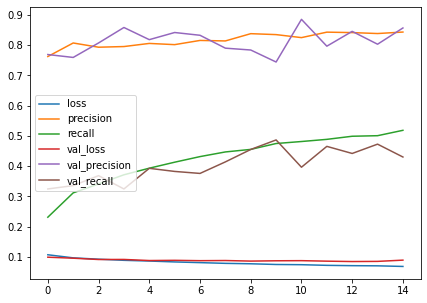

 113/1218 [=>............................] - ETA: 1s - loss: 24.9415 - precision: 0.0499 - recall: 0.7222 - f1_score: 0.0933

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1218/1218 [==============================] - 2s 1ms/step - loss: 25.3473 - precision: 0.0467 - recall: 0.6628 - f1_score: 0.0872
Epoch 1/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.1072 - precision: 0.7824 - recall: 0.2400 - f1_score: 0.3673 - val_loss: 0.0998 - val_precision: 0.7487 - val_recall: 0.3277 - val_f1_score: 0.4559
Epoch 2/15
4872/4872 [==============================] - 12s 2ms/step - loss: 0.0966 - precision: 0.8105 - recall: 0.2948 - f1_score: 0.4323 - val_loss: 0.0945 - val_precision: 0.7886 - val_recall: 0.3336 - val_f1_score: 0.4688
Epoch 3/15
4872/4872 [==============================] - 12s 2ms/step - loss: 0.0930 - precision: 0.8131 - recall: 0.3094 - f1_score: 0.4483 - val_loss: 0.0924 - val_precision: 0.7793 - val_recall: 0.3416 - val_f1_score: 0.4750
Epoch 4/15
4872/4872 [==============================] - 12s 2ms/step - loss: 0.0892 - precision: 0.8174 - recall: 0.3175 - f1_score: 0.4574 - val_loss: 0.0929 - val_precision: 0.8275 - val_r

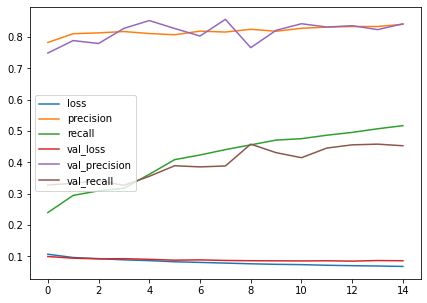

 113/1218 [=>............................] - ETA: 1s - loss: 31.5093 - precision: 0.0460 - recall: 0.7063 - f1_score: 0.0864

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1218/1218 [==============================] - 2s 1ms/step - loss: 31.8371 - precision: 0.0440 - recall: 0.6708 - f1_score: 0.0826
Epoch 1/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.1069 - precision: 0.7863 - recall: 0.2434 - f1_score: 0.3718 - val_loss: 0.0989 - val_precision: 0.8704 - val_recall: 0.2610 - val_f1_score: 0.4016
Epoch 2/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0966 - precision: 0.7921 - recall: 0.2990 - f1_score: 0.4341 - val_loss: 0.0963 - val_precision: 0.8692 - val_recall: 0.2874 - val_f1_score: 0.4320
Epoch 3/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0921 - precision: 0.8020 - recall: 0.3208 - f1_score: 0.4583 - val_loss: 0.0928 - val_precision: 0.8164 - val_recall: 0.3292 - val_f1_score: 0.4692
Epoch 4/15
4872/4872 [==============================] - 12s 2ms/step - loss: 0.0892 - precision: 0.8074 - recall: 0.3534 - f1_score: 0.4916 - val_loss: 0.0912 - val_precision: 0.7914 - val_r

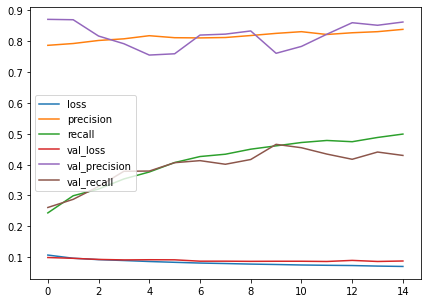

 120/1218 [=>............................] - ETA: 1s - loss: 22.8522 - precision: 0.0485 - recall: 0.7218 - f1_score: 0.0910

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1218/1218 [==============================] - 2s 1ms/step - loss: 23.1418 - precision: 0.0456 - recall: 0.6642 - f1_score: 0.0853
Epoch 1/15
4872/4872 [==============================] - 14s 3ms/step - loss: 0.1067 - precision: 0.7679 - recall: 0.2341 - f1_score: 0.3588 - val_loss: 0.0996 - val_precision: 0.7556 - val_recall: 0.3196 - val_f1_score: 0.4493
Epoch 2/15
4872/4872 [==============================] - 12s 3ms/step - loss: 0.0971 - precision: 0.7949 - recall: 0.3019 - f1_score: 0.4376 - val_loss: 0.0966 - val_precision: 0.8391 - val_recall: 0.3021 - val_f1_score: 0.4442
Epoch 3/15
4872/4872 [==============================] - 12s 2ms/step - loss: 0.0935 - precision: 0.8038 - recall: 0.3109 - f1_score: 0.4484 - val_loss: 0.0949 - val_precision: 0.8909 - val_recall: 0.2515 - val_f1_score: 0.3922
Epoch 4/15
4872/4872 [==============================] - 12s 3ms/step - loss: 0.0898 - precision: 0.8111 - recall: 0.3415 - f1_score: 0.4807 - val_loss: 0.0941 - val_precision: 0.8398 - val_r

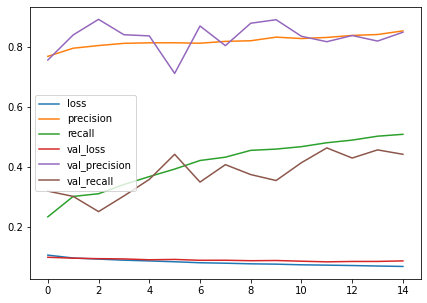

 120/1218 [=>............................] - ETA: 1s - loss: 34.6262 - precision: 0.0478 - recall: 0.7444 - f1_score: 0.0898

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1218/1218 [==============================] - 2s 1ms/step - loss: 35.4478 - precision: 0.0454 - recall: 0.6994 - f1_score: 0.0853
Epoch 1/15
4872/4872 [==============================] - 14s 3ms/step - loss: 0.1086 - precision: 0.7457 - recall: 0.2359 - f1_score: 0.3584 - val_loss: 0.1005 - val_precision: 0.9026 - val_recall: 0.2309 - val_f1_score: 0.3678
Epoch 2/15
4872/4872 [==============================] - 12s 3ms/step - loss: 0.0978 - precision: 0.7976 - recall: 0.2977 - f1_score: 0.4336 - val_loss: 0.0980 - val_precision: 0.7868 - val_recall: 0.2977 - val_f1_score: 0.4319
Epoch 3/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0933 - precision: 0.7867 - recall: 0.3347 - f1_score: 0.4697 - val_loss: 0.0942 - val_precision: 0.8838 - val_recall: 0.2845 - val_f1_score: 0.4304
Epoch 4/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0893 - precision: 0.7998 - recall: 0.3588 - f1_score: 0.4953 - val_loss: 0.0919 - val_precision: 0.8328 - val_r

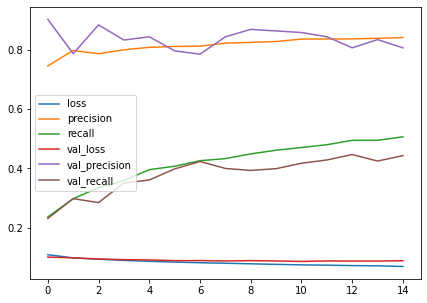

 110/1218 [=>............................] - ETA: 1s - loss: 34.9898 - precision: 0.0490 - recall: 0.7742 - f1_score: 0.0922

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1218/1218 [==============================] - 2s 1ms/step - loss: 35.5686 - precision: 0.0452 - recall: 0.7163 - f1_score: 0.0850
Epoch 1/15
4872/4872 [==============================] - 14s 3ms/step - loss: 0.1073 - precision: 0.7680 - recall: 0.2348 - f1_score: 0.3597 - val_loss: 0.1022 - val_precision: 0.8952 - val_recall: 0.2317 - val_f1_score: 0.3681
Epoch 2/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0976 - precision: 0.8034 - recall: 0.2951 - f1_score: 0.4317 - val_loss: 0.0983 - val_precision: 0.7328 - val_recall: 0.3438 - val_f1_score: 0.4681
Epoch 3/15
4872/4872 [==============================] - 12s 3ms/step - loss: 0.0931 - precision: 0.8076 - recall: 0.3201 - f1_score: 0.4584 - val_loss: 0.0984 - val_precision: 0.8591 - val_recall: 0.2815 - val_f1_score: 0.4241
Epoch 4/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0899 - precision: 0.8125 - recall: 0.3575 - f1_score: 0.4965 - val_loss: 0.0923 - val_precision: 0.7983 - val_r

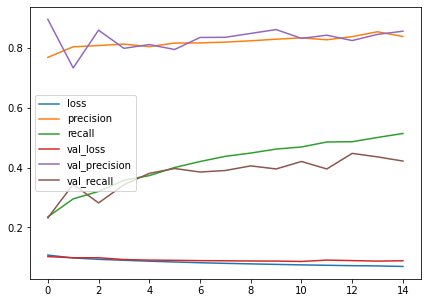

 115/1218 [=>............................] - ETA: 1s - loss: 36.3753 - precision: 0.0492 - recall: 0.7442 - f1_score: 0.0922

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1218/1218 [==============================] - 2s 1ms/step - loss: 37.0632 - precision: 0.0449 - recall: 0.6752 - f1_score: 0.0842
Epoch 1/15
4872/4872 [==============================] - 14s 3ms/step - loss: 0.1075 - precision: 0.7549 - recall: 0.2478 - f1_score: 0.3732 - val_loss: 0.0987 - val_precision: 0.7656 - val_recall: 0.3065 - val_f1_score: 0.4377
Epoch 2/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0973 - precision: 0.8039 - recall: 0.2992 - f1_score: 0.4361 - val_loss: 0.0954 - val_precision: 0.8565 - val_recall: 0.2713 - val_f1_score: 0.4120
Epoch 3/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0933 - precision: 0.8025 - recall: 0.3120 - f1_score: 0.4493 - val_loss: 0.0938 - val_precision: 0.8327 - val_recall: 0.3028 - val_f1_score: 0.4441
Epoch 4/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0897 - precision: 0.8054 - recall: 0.3580 - f1_score: 0.4957 - val_loss: 0.0914 - val_precision: 0.7976 - val_r

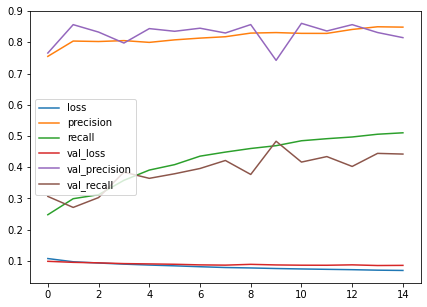

 108/1218 [=>............................] - ETA: 1s - loss: 39.1033 - precision: 0.0478 - recall: 0.7541 - f1_score: 0.0899

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1218/1218 [==============================] - 2s 2ms/step - loss: 39.9151 - precision: 0.0442 - recall: 0.6987 - f1_score: 0.0832
Epoch 1/15
4872/4872 [==============================] - 14s 3ms/step - loss: 0.1072 - precision: 0.7605 - recall: 0.2416 - f1_score: 0.3667 - val_loss: 0.1000 - val_precision: 0.8785 - val_recall: 0.2331 - val_f1_score: 0.3685
Epoch 2/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0973 - precision: 0.7992 - recall: 0.2984 - f1_score: 0.4346 - val_loss: 0.0956 - val_precision: 0.7799 - val_recall: 0.3299 - val_f1_score: 0.4637
Epoch 3/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0939 - precision: 0.8063 - recall: 0.3144 - f1_score: 0.4524 - val_loss: 0.0951 - val_precision: 0.7450 - val_recall: 0.3534 - val_f1_score: 0.4794
Epoch 4/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0910 - precision: 0.8178 - recall: 0.3226 - f1_score: 0.4627 - val_loss: 0.0921 - val_precision: 0.8150 - val_r

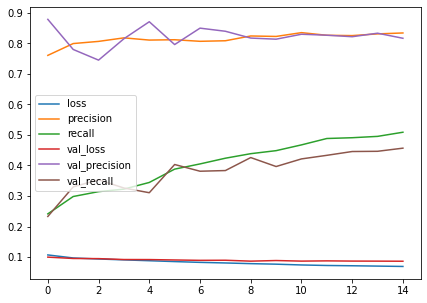

 111/1218 [=>............................] - ETA: 1s - loss: 19.7709 - precision: 0.0517 - recall: 0.6935 - f1_score: 0.0961

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1218/1218 [==============================] - 2s 1ms/step - loss: 20.1400 - precision: 0.0476 - recall: 0.6312 - f1_score: 0.0886
Epoch 1/15
4872/4872 [==============================] - 14s 3ms/step - loss: 0.1068 - precision: 0.7767 - recall: 0.2398 - f1_score: 0.3664 - val_loss: 0.1013 - val_precision: 0.8654 - val_recall: 0.2639 - val_f1_score: 0.4045
Epoch 2/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0971 - precision: 0.7985 - recall: 0.2972 - f1_score: 0.4331 - val_loss: 0.0954 - val_precision: 0.8064 - val_recall: 0.3145 - val_f1_score: 0.4525
Epoch 3/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0935 - precision: 0.8054 - recall: 0.3089 - f1_score: 0.4465 - val_loss: 0.0941 - val_precision: 0.8024 - val_recall: 0.3365 - val_f1_score: 0.4742
Epoch 4/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0904 - precision: 0.8104 - recall: 0.3212 - f1_score: 0.4600 - val_loss: 0.0928 - val_precision: 0.7993 - val_r

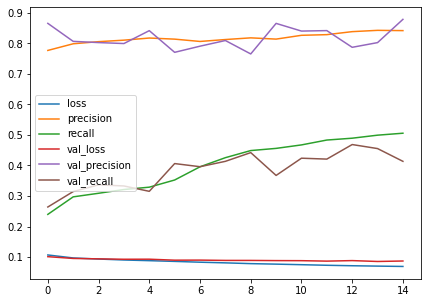

 106/1218 [=>............................] - ETA: 1s - loss: 26.7358 - precision: 0.0490 - recall: 0.7203 - f1_score: 0.0918

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1218/1218 [==============================] - 2s 1ms/step - loss: 27.1034 - precision: 0.0445 - recall: 0.6415 - f1_score: 0.0832
Epoch 1/15
4872/4872 [==============================] - 14s 3ms/step - loss: 0.1066 - precision: 0.7982 - recall: 0.2422 - f1_score: 0.3716 - val_loss: 0.1000 - val_precision: 0.8226 - val_recall: 0.2823 - val_f1_score: 0.4203
Epoch 2/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0971 - precision: 0.8020 - recall: 0.2984 - f1_score: 0.4350 - val_loss: 0.1000 - val_precision: 0.8700 - val_recall: 0.2698 - val_f1_score: 0.4119
Epoch 3/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0939 - precision: 0.8047 - recall: 0.3142 - f1_score: 0.4519 - val_loss: 0.0941 - val_precision: 0.8881 - val_recall: 0.2676 - val_f1_score: 0.4113
Epoch 4/15
4872/4872 [==============================] - 13s 3ms/step - loss: 0.0905 - precision: 0.8067 - recall: 0.3228 - f1_score: 0.4611 - val_loss: 0.0927 - val_precision: 0.8076 - val_r

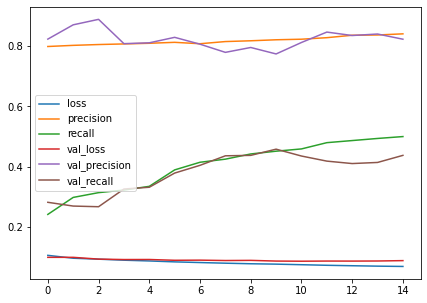

 104/1218 [=>............................] - ETA: 1s - loss: 22.8152 - precision: 0.0512 - recall: 0.7414 - f1_score: 0.0958

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1218/1218 [==============================] - 2s 1ms/step - loss: 23.4401 - precision: 0.0464 - recall: 0.6657 - f1_score: 0.0867


In [ ]:
TH = 0.5
REPETITION = 10
results_unbalanced = {}
results_unbalanced['f1_score'] = []
results_unbalanced['precision'] = []
results_unbalanced['recall'] = []

class_weight = {0: 1.,
                1: 2.}

#input_ = keras.layers.Input(shape=df1_x_train.shape[1:])
#model = keras.Model(inputs=[input_], outputs=[base_model])

for i in range(REPETITION):
    model_1 = get_model()
    model_1.compile(loss="binary_crossentropy", optimizer="adam", metrics=[keras.metrics.Precision(name="precision", thresholds=TH), keras.metrics.Recall(name="recall", thresholds=TH), tfa.metrics.F1Score(num_classes=1, threshold=TH)]) # keras.metrics.AUC(name='auc'),

    history = model_1.fit(np.asarray(df1_x_train_less_val), np.asarray(df1_y_train_less_val), validation_data=(np.asarray(df1_x_val), np.asarray(df1_y_val)), batch_size=32, epochs=15)

    # Plotting history
    pd.DataFrame(history.history).plot(figsize=(7, 5))
    plt.show()

    # Evaluate on the test set
    result = model_1.evaluate(np.asarray(df1_x_test), np.asarray(df1_y_test), return_dict=True)
    results_unbalanced['f1_score'].append(result['f1_score'][0])
    results_unbalanced['precision'].append(result['precision'])
    results_unbalanced['recall'].append(result['recall'])

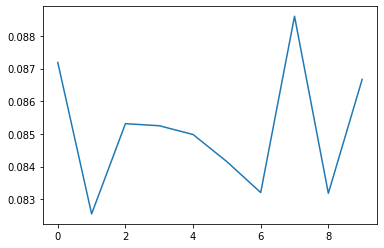

In [ ]:
plt.plot(results_unbalanced['f1_score'])

## RESAMPLING

In [ ]:
# RESAMPLING

from imblearn.combine import SMOTETomek

print(sorted(Counter(df1_y_train_less_val).items()))
smote_tomek = SMOTETomek(random_state=RANDOM_STATE)
df1_x_train_less_val_resampled, df1_y_train_less_val_resampled = smote_tomek.fit_resample(df1_x_train_less_val, df1_y_train_less_val)
print(sorted(Counter(df1_y_train_less_val_resampled).items()))

[(0, 150448), (1, 5455)]


In [ ]:
REPETITION = 10
results_resampling = {}
results_resampling['f1_score'] = []
results_resampling['precision'] = []
results_resampling['recall'] = []

for i in range(REPETITION):
    model_1 = get_model()
    model_1.compile(loss="binary_crossentropy", optimizer="adam", metrics=[keras.metrics.Precision(name="precision", thresholds=TH), keras.metrics.Recall(name="recall", thresholds=TH), tfa.metrics.F1Score(num_classes=1, threshold=TH)])

    history = model_1.fit(np.asarray(df1_x_train_less_val_resampled), np.asarray(df1_y_train_less_val_resampled), validation_data=(np.asarray(df1_x_val), np.asarray(df1_y_val)), batch_size=32, epochs=15)

    # Plotting history
    pd.DataFrame(history.history).plot(figsize=(7, 5))
    plt.show()

    # Evaluate on the test set
    result = model_1.evaluate(np.asarray(df1_x_test), np.asarray(df1_y_test), return_dict=True)
    results_resampling['f1_score'].append(result['f1_score'][0])
    results_resampling['precision'].append(result['precision'])
    results_resampling['recall'].append(result['recall'])

In [ ]:
plt.plot(results_resampling['f1_score'])

## FEDERATED LEARNING

In [ ]:
# !pip uninstall --yes tensorboard tb-nightly

# !pip install --quiet --upgrade tensorflow-federated-nightly
# !pip install --quiet --upgrade nest-asyncio
# !pip install --quiet --upgrade tb-nightly  # or tensorboard, but not both

# import nest_asyncio
# nest_asyncio.apply()

In [ ]:
# import tensorflow_federated as tff
import collections
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
client_train_dataset = collections.OrderedDict()
client_train_dataset['client_1'] = collections.OrderedDict((('y', df1_y_train), ('x', df1_x_train)))
client_train_dataset['client_2'] = collections.OrderedDict((('y', df2_y_train), ('x', df2_x_train)))
client_train_dataset['client_3'] = collections.OrderedDict((('y', df3_y_train), ('x', df3_x_train)))
train_dataset = tff.simulation.datasets.TestClientData(client_train_dataset)

In [ ]:
NUM_CLIENTS = 3
NUM_EPOCHS = 15
BATCH_SIZE = 32
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):
  def batch_format_fn(element):
    return collections.OrderedDict(
        x=element['x'],
        y=tf.reshape(element['y'], [-1, 1]))
  #return dataset.batch(BATCH_SIZE).map(batch_format_fn)
  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)
  

def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]


In [ ]:
sample_clients = train_dataset.client_ids[0:NUM_CLIENTS] # ['client_1', 'client_2', 'client_3']

federated_train_data = make_federated_data(train_dataset, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 3
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 505)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>


In [ ]:
sample_dataset = train_dataset.create_tf_dataset_for_client(train_dataset.client_ids[0])
sample_element = next(iter(sample_dataset))
preprocessed_sample_dataset = preprocess(sample_dataset)

In [ ]:
preprocessed_sample_dataset.element_spec

OrderedDict([('x', TensorSpec(shape=(None, 505), dtype=tf.float64, name=None)),
             ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])

### Create federated model

In [ ]:
from tensorflow.keras import optimizers
TH = 0.5

def model_tff():
  model = get_model()
  return tff.learning.from_keras_model(
      model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[
               tfa.metrics.F1Score(num_classes=1, threshold=TH),
               keras.metrics.Precision(name="precision", thresholds=TH),
               keras.metrics.Recall(name="recall", thresholds=TH)
              ])


In [ ]:
client_lr = 1e-3  # default for Keras Adam optimizer
server_lr = 1e-1

iterative_process = tff.learning.build_federated_averaging_process(
    model_tff,
    client_optimizer_fn=lambda: optimizers.Adam(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.SGD(learning_rate=server_lr))

### Run federated simulations

In [ ]:
# evaluation_process = tff.learning.build_federated_evaluation(model_tff)
import datetime
import nest_asyncio
nest_asyncio.apply()
%load_ext tensorboard


REPETITION = 10
results_fl = {}
results_fl['f1_score'] = []
results_fl['precision'] = []
results_fl['recall'] = []

for i in range(REPETITION):

    state = iterative_process.initialize()

    log_dir = "logs/fit/federated-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    #%tensorboard --logdir logs/fit. # activate tensorflow in cell

    summary_writer_train = tf.summary.create_file_writer(log_dir+'/train')
    summary_writer_val = tf.summary.create_file_writer(log_dir+'/val')

    federated_model = None
    NUM_ROUNDS = 15
    for round_num in range(1, NUM_ROUNDS+1):

        #train_data_sharded = [federated_train_data[0].shard(num_shards=NUM_ROUNDS, index=NUM_ROUNDS-1), federated_train_data[1].shard(num_shards=NUM_ROUNDS, index=NUM_ROUNDS-1), federated_train_data[2].shard(num_shards=NUM_ROUNDS, index=NUM_ROUNDS-1)]
        #state, tff_metrics = iterative_process.next(state, train_data_sharded)
        
        state, tff_metrics = iterative_process.next(state, federated_train_data)
        
        federated_model = get_model()
        federated_model.compile(optimizer="adam",
                            loss=tf.keras.losses.BinaryCrossentropy(),
                            metrics=[
                                tfa.metrics.F1Score(num_classes=1, threshold=TH),
                                keras.metrics.Precision(name="precision", thresholds=TH),keras.metrics.Recall(name="recall", thresholds=TH)
                                ])
        state.model.assign_weights_to(model=federated_model)
        federated_result = federated_model.evaluate(np.asarray(df1_x_val), np.asarray(df1_y_val), verbose=0, return_dict=True)
        with summary_writer_train.as_default():
            for name, metric in tff_metrics['train'].items():
                if name=='f1_score':
                    tf.summary.scalar(name, metric[0], round_num)
                else:
                    tf.summary.scalar(name, metric, round_num)
        with summary_writer_val.as_default():
            for name, metric in federated_result.items():
                if name=='f1_score':
                    tf.summary.scalar(name, metric[0], round_num)
                else:
                    tf.summary.scalar(name, metric, round_num)    

    federated_test = federated_model.evaluate(np.asarray(df1_x_test), np.asarray(df1_y_test), verbose=0, return_dict=True)
    results_fl['f1_score'].append(federated_test['f1_score'][0])
    results_fl['precision'].append(federated_test['precision'])
    results_fl['recall'].append(federated_test['recall'])

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


In [ ]:
plt.plot(results_fl['f1_score'])

In [ ]:
plt.figure(figsize=(10,7))

plt.errorbar(1, np.mean(results_unbalanced['f1_score']), yerr=np.std(results_unbalanced['f1_score'], axis=0), fmt='ok', ecolor='gray',color='black',  elinewidth=3, capsize=10)

plt.errorbar(2, np.mean(results_resampling['f1_score']), yerr=np.std(results_resampling['f1_score'], axis=0), fmt='ok', color='black',  ecolor='gray', elinewidth=3, capsize=10)

plt.errorbar(3, np.mean(results_gan['f1_score']), yerr=np.std(results_gan['f1_score'], axis=0), fmt='ok', color='black',  ecolor='gray',elinewidth=3, capsize=10)

plt.errorbar(4, np.mean(results_fl['f1_score']), yerr=np.std(results_fl['f1_score'], axis=0), fmt='ok', color='black', ecolor='gray', elinewidth=3, capsize=10)

plt.ylabel('F1 score')
xlabels = ['Class\nWeight', 'Resampling', 'SynthData\nCTGAN', 'Federated\nLearning']
plt.xticks([1,2,3,4], xlabels, rotation='vertical')
plt.grid(axis='y')
plt.rcParams.update({'font.size': 25})
plt.savefig('./comparing.png', dpi=300, bbox_inches='tight')
plt.show()
